
# TIP3P/TIP4P Water Model Simulation in OpenMM

This notebook simulates a box of water using the TIP4P-D model and analyzes:
- The velocity autocorrelation function (VACF)
- The radial distribution function (g(r))

We use OpenMM for simulation and MDTraj + NumPy for analysis.


In [ ]:
!pip install -q condacolab
import condacolab
condacolab.install()

In [ ]:
%%capture
!conda install -c conda-forge openmm mdtraj parmed

In [ ]:
import openmm
from openmm import *
from openmm.app import *
from openmm.unit import nanometers

import matplotlib.pyplot as plt
import mdtraj  as md
import numpy   as np
import pandas  as pd

import openmmtools
from   openmmtools  import testsystems

In [66]:
from openmmtools import testsystems

#waterbox = testsystems.WaterBox(model='tip4pew', box_edge=3.0*nanometers)
waterbox = testsystems.WaterBox(model='tip3p', box_edge=3.0*nanometers)

system = waterbox.system
topology = waterbox.topology
positions = waterbox.positions

from openmm.app import PDBFile
with open("tip3p_box.pdb", "w") as f:
    PDBFile.writeFile(waterbox.topology, waterbox.positions, f)

In [78]:
#import nglview as nv

#pdb = md.load_pdb("tip3p_box.pdb")
#view = nv.show_mdtraj(pdb)
#view.add_ball_and_stick('all')
#view.center_view(zoom=True)
#view

In [ ]:
nonbondedMethod     = PME
nonbondedCutoff     = 1.0*nanometers
ewaldErrorTolerance = 0.0005
constraints         = HBonds
rigidWater          = True
constraintTolerance = 0.000001
hydrogenMass        = 1.5*amu

dt               = 0.002*picoseconds
temperature      = 300*kelvin
friction         = 1.0/picosecond
pressure         = 1.0*atmospheres
barostatInterval = 25

# Simulation Options
nsteps = int(10000)   # run for 1e6 steps = 1ns

In [69]:
dcdReporter        = DCDReporter('trajectory.dcd', 100)
dataReporter       = StateDataReporter('log.txt', 1000, 
                                 totalSteps=steps,
                                 step=True, 
                                 speed=True, progress=True, 
                                 potentialEnergy=True, 
                                 temperature=True, 
                                 separator='\t')

# Prepare the Simulation
system.addForce(MonteCarloBarostat(pressure, temperature, barostatInterval))

integrator = LangevinMiddleIntegrator(temperature, friction, dt)
integrator.setConstraintTolerance(constraintTolerance)
simulation = Simulation(topology, system, integrator)
simulation.context.setPositions(positions)

# Minimize 
simulation.minimizeEnergy()

# Simulate
simulation.context.setVelocitiesToTemperature(temperature)
simulation.reporters.append(dcdReporter)
simulation.reporters.append(dataReporter)

simulation.step(nsteps)

### Analyize Simulation Results

In [70]:
# Load trajectory and extract velocities
traj = md.load('trajectory.dcd', top='tip3p_box.pdb')
n_frames = traj.n_frames
n_atoms = traj.n_atoms

### RDF

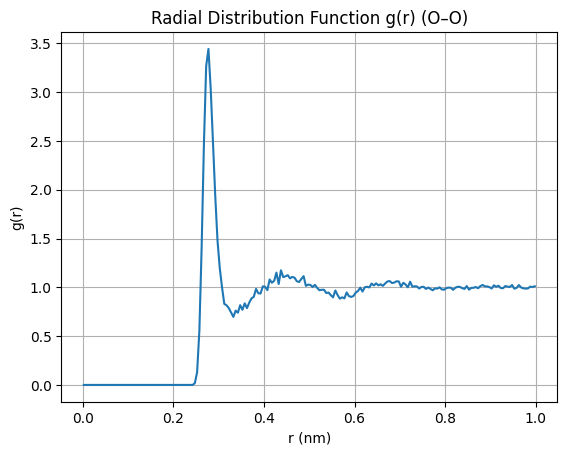

In [71]:
import numpy as np
import itertools
import matplotlib.pyplot as plt

# Select oxygen atoms
oxygen_indices = traj.topology.select("name O")

# Generate all unique O–O pairs (no self-pairs, no duplicates)
pairs = np.array(list(itertools.combinations(oxygen_indices, 2)))

# Compute radial distribution function
rdf, r = md.compute_rdf(traj, pairs=pairs, r_range=(0.0, 1.0))

# Plot
plt.plot(rdf, r)
plt.title("Radial Distribution Function g(r) (O–O)")
plt.xlabel("r (nm)")
plt.ylabel("g(r)")
plt.grid()
plt.show()


### VACF

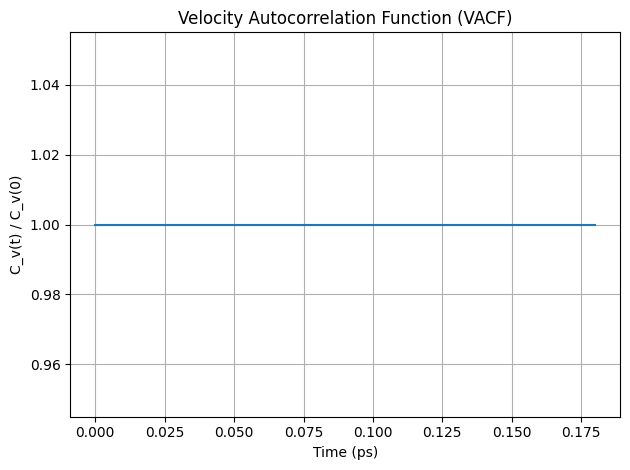

In [77]:
# Compute VACF using NumPy
context = simulation.context
velocities = np.zeros((n_frames, n_atoms, 3))

for i in range(n_frames):
    simulation.context.setState(simulation.context.getState(getVelocities=True))
    velocities[i] = simulation.context.getState(getVelocities=True).getVelocities(asNumpy=True)._value

vacf = np.zeros(n_frames)
v0 = velocities[0]


# Assume: velocities.shape = (n_frames, n_atoms, 3)
n_frames = velocities.shape[0]

# VACF calculation
vacf = np.zeros(n_frames)
for t in range(n_frames):
    vt = velocities[t]
    vacf[t] = np.mean(np.sum(v0 * vt, axis=1))  # dot each atom's velocity, then average

# Normalize
vacf /= vacf[0]

# Time in picoseconds (adjust if your frame spacing is not 1 step = 2 fs)
timestep_fs = 2
frame_interval = 10  # if saved every 10 steps
time = np.arange(n_frames) * timestep_fs * frame_interval * 1e-3  # ps

# Plot
plt.plot(time, vacf)
plt.title("Velocity Autocorrelation Function (VACF)")
plt.xlabel("Time (ps)")
plt.ylabel("C_v(t) / C_v(0)")
plt.grid(True)
plt.tight_layout()
plt.show()

